In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [79]:
from IPython.display import display
import re
import matplotlib.pyplot as plt


In [7]:
!pip install -q gdown

In [9]:
!pip install -q -U gdown

In [70]:
!gdown --folder --fuzzy "https://drive.google.com/drive/folders/1tAEIObd25p8JeqFVLS2ef70uIuHLykxX"

Retrieving folder contents
Processing file 1o0NEU9EtFkrtvd9JacSLGO86KdMjd2Z7 sample-README.md
Processing file 1PaS5kJruNOy8OY6BZD_Ze5r3Y0Gowfse test.txt
Processing file 1-c20gJwbzjLsUWFFKbC1OOKxUb17MHSk train.txt
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1o0NEU9EtFkrtvd9JacSLGO86KdMjd2Z7
To: /kaggle/working/DATA/sample-README.md
100%|██████████████████████████████████████| 1.64k/1.64k [00:00<00:00, 7.05MB/s]
Downloading...
From: https://drive.google.com/uc?id=1PaS5kJruNOy8OY6BZD_Ze5r3Y0Gowfse
To: /kaggle/working/DATA/test.txt
100%|███████████████████████████████████████| 56.8M/56.8M [00:00<00:00, 206MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1-c20gJwbzjLsUWFFKbC1OOKxUb17MHSk
From (redirected): https://drive.google.com/uc?id=1-c20gJwbzjLsUWFFKbC1OOKxUb17MHSk&confirm=t&uuid=2cfe52d5-32c7-4c14-a8c2-04705c8826a9
To: /kaggle/working/DATA/train.txt
100%

In [51]:
!ls /kaggle/working/DATA

sample-README.md  test.txt  train.txt


In [52]:
DATA_DIR = "/kaggle/working/DATA"

In [53]:
path = "/kaggle/working/DATA/train.txt"

with open(path, "r", encoding="utf-8") as f:
    for i in range(5):
        print(f.readline().rstrip())


199.72.81.55 - - [01/Jul/1995:00:00:01 -0400] "GET /history/apollo/ HTTP/1.0" 200 6245
unicomp6.unicomp.net - - [01/Jul/1995:00:00:06 -0400] "GET /shuttle/countdown/ HTTP/1.0" 200 3985
199.120.110.21 - - [01/Jul/1995:00:00:09 -0400] "GET /shuttle/missions/sts-73/mission-sts-73.html HTTP/1.0" 200 4085
burger.letters.com - - [01/Jul/1995:00:00:11 -0400] "GET /shuttle/countdown/liftoff.html HTTP/1.0" 304 0
199.120.110.21 - - [01/Jul/1995:00:00:11 -0400] "GET /shuttle/missions/sts-73/sts-73-patch-small.gif HTTP/1.0" 200 4179


In [54]:
LOG_PATTERN = re.compile(
    r'(?P<host>\S+) \S+ \S+ '
    r'\[(?P<datetime>[^\]]+)\] '
    r'"(?P<method>\S+) (?P<path>\S+) (?P<protocol>[^"]+)" '
    r'(?P<status>\d{3}) (?P<bytes>\S+)'
)

def parse_apache_logs(paths):
    """
    Parse Apache/NASA log files into a pandas DataFrame.

    Args:
        paths (list[str]): list of log file paths

    Returns:
        pd.DataFrame
    """
    rows = []

    for path in paths:
        with open(path, "r", encoding="utf-8") as f:
            for line in f:
                match = LOG_PATTERN.search(line)
                if not match:
                    continue

                row = match.groupdict()
                row["bytes"] = 0 if row["bytes"] == "-" else int(row["bytes"])
                row["status"] = int(row["status"])
                row["source_file"] = path.split("/")[-1]
                rows.append(row)

    return pd.DataFrame(rows)

In [66]:
def add_time_features(df):
    """
    Clean and enrich parsed logs with datetime and features.
    """
    df = df.copy()

    # Parse datetime
    df["datetime"] = pd.to_datetime(
        df["datetime"],
        format="%d/%b/%Y:%H:%M:%S %z",
        errors="coerce"
    )

    # Time features
    df["hour"] = df["datetime"].dt.hour
    df["weekday"] = df["datetime"].dt.weekday
    df["is_weekend"] = df["weekday"].isin([5, 6]).astype(int)


    return df


In [72]:
def optimize_memory(df):
    """
    Reduce memory usage for large log DataFrames.
    """
    df = df.copy()

    for col in ["method", "protocol"]:
        df[col] = df[col].astype("category")

    return df


In [73]:
def build_csv(input_txt, output_csv):
    df = parse_apache_logs([input_txt])
    df = add_time_features(df)
    df = optimize_memory(df)
    df.to_csv(output_csv, index=False)
    return df

In [75]:
train = build_csv(
    "/kaggle/working/DATA/train.txt",
    "/kaggle/working/train.csv"
)

test = build_csv(
    "/kaggle/working/DATA/test.txt",
    "/kaggle/working/test.csv"
)

In [76]:
!ls /kaggle/working

DATA  test.csv	train.csv


In [77]:
train = pd.read_csv("/kaggle/working/train.csv")
train.tail()

,host,datetime,method,path,protocol,status,bytes,source_file,hour,weekday,is_weekend
2930719,sfsp129.slip.net,1995-08-22 23:59:55-04:00,GET,/images/ksclogo-medium.gif,HTTP/1.0,200,5866,train.txt,23,1,0
2930720,sfsp129.slip.net,1995-08-22 23:59:57-04:00,GET,/images/NASA-logosmall.gif,HTTP/1.0,200,786,train.txt,23,1,0
2930721,sfsp129.slip.net,1995-08-22 23:59:57-04:00,GET,/images/MOSAIC-logosmall.gif,HTTP/1.0,200,363,train.txt,23,1,0
2930722,sfsp129.slip.net,1995-08-22 23:59:58-04:00,GET,/images/USA-logosmall.gif,HTTP/1.0,200,234,train.txt,23,1,0
2930723,sfsp129.slip.net,1995-08-22 23:59:59-04:00,GET,/images/WORLD-logosmall.gif,HTTP/1.0,200,669,train.txt,23,1,0


In [78]:
test = pd.read_csv("/kaggle/working/test.csv")
test.head()

,host,datetime,method,path,protocol,status,bytes,source_file,hour,weekday,is_weekend
0,ix-mia1-02.ix.netcom.com,1995-08-23 00:00:00-04:00,GET,/ksc.html,HTTP/1.0,200,7087,test.txt,0,2,0
1,internet-gw.watson.ibm.com,1995-08-23 00:00:05-04:00,GET,/history/apollo/pad-abort-test-2/pad-abort-tes...,HTTP/1.0,200,1292,test.txt,0,2,0
2,ix-mia1-02.ix.netcom.com,1995-08-23 00:00:06-04:00,GET,/images/ksclogo-medium.gif,HTTP/1.0,200,5866,test.txt,0,2,0
3,internet-gw.watson.ibm.com,1995-08-23 00:00:08-04:00,GET,/history/apollo/pad-abort-test-2/pad-abort-tes...,HTTP/1.0,200,1625,test.txt,0,2,0
4,internet-gw.watson.ibm.com,1995-08-23 00:00:10-04:00,GET,/history/apollo/pad-abort-test-2/pad-abort-tes...,HTTP/1.0,404,0,test.txt,0,2,0


In [80]:
display(train.head())
display(test.head())

,host,datetime,method,path,protocol,status,bytes,source_file,hour,weekday,is_weekend
0,199.72.81.55,1995-07-01 00:00:01-04:00,GET,/history/apollo/,HTTP/1.0,200,6245,train.txt,0,5,1
1,unicomp6.unicomp.net,1995-07-01 00:00:06-04:00,GET,/shuttle/countdown/,HTTP/1.0,200,3985,train.txt,0,5,1
2,199.120.110.21,1995-07-01 00:00:09-04:00,GET,/shuttle/missions/sts-73/mission-sts-73.html,HTTP/1.0,200,4085,train.txt,0,5,1
3,burger.letters.com,1995-07-01 00:00:11-04:00,GET,/shuttle/countdown/liftoff.html,HTTP/1.0,304,0,train.txt,0,5,1
4,199.120.110.21,1995-07-01 00:00:11-04:00,GET,/shuttle/missions/sts-73/sts-73-patch-small.gif,HTTP/1.0,200,4179,train.txt,0,5,1


,host,datetime,method,path,protocol,status,bytes,source_file,hour,weekday,is_weekend
0,ix-mia1-02.ix.netcom.com,1995-08-23 00:00:00-04:00,GET,/ksc.html,HTTP/1.0,200,7087,test.txt,0,2,0
1,internet-gw.watson.ibm.com,1995-08-23 00:00:05-04:00,GET,/history/apollo/pad-abort-test-2/pad-abort-tes...,HTTP/1.0,200,1292,test.txt,0,2,0
2,ix-mia1-02.ix.netcom.com,1995-08-23 00:00:06-04:00,GET,/images/ksclogo-medium.gif,HTTP/1.0,200,5866,test.txt,0,2,0
3,internet-gw.watson.ibm.com,1995-08-23 00:00:08-04:00,GET,/history/apollo/pad-abort-test-2/pad-abort-tes...,HTTP/1.0,200,1625,test.txt,0,2,0
4,internet-gw.watson.ibm.com,1995-08-23 00:00:10-04:00,GET,/history/apollo/pad-abort-test-2/pad-abort-tes...,HTTP/1.0,404,0,test.txt,0,2,0


In [81]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930724 entries, 0 to 2930723
Data columns (total 11 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   host         object
 1   datetime     object
 2   method       object
 3   path         object
 4   protocol     object
 5   status       int64 
 6   bytes        int64 
 7   source_file  object
 8   hour         int64 
 9   weekday      int64 
 10  is_weekend   int64 
dtypes: int64(5), object(6)
memory usage: 246.0+ MB


In [82]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525975 entries, 0 to 525974
Data columns (total 11 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   host         525975 non-null  object
 1   datetime     525975 non-null  object
 2   method       525975 non-null  object
 3   path         525975 non-null  object
 4   protocol     525975 non-null  object
 5   status       525975 non-null  int64 
 6   bytes        525975 non-null  int64 
 7   source_file  525975 non-null  object
 8   hour         525975 non-null  int64 
 9   weekday      525975 non-null  int64 
 10  is_weekend   525975 non-null  int64 
dtypes: int64(5), object(6)
memory usage: 44.1+ MB


In [83]:
train.isna().sum()

host           0
datetime       0
method         0
path           0
protocol       0
status         0
bytes          0
source_file    0
hour           0
weekday        0
is_weekend     0
dtype: int64

In [84]:
test.isna().sum()

host           0
datetime       0
method         0
path           0
protocol       0
status         0
bytes          0
source_file    0
hour           0
weekday        0
is_weekend     0
dtype: int64

In [85]:
display((train["bytes"] == 0).mean() * 100)
display((test["bytes"] == 0).mean() * 100)

np.float64(8.59207485931804)

np.float64(11.75854365701792)

In [86]:
train.loc[train["bytes"] == 0, "status"].value_counts(normalize=True) * 100


status
304    84.369961
404     6.715778
302     4.441841
200     4.391009
403     0.044478
500     0.024622
501     0.012311
Name: proportion, dtype: float64

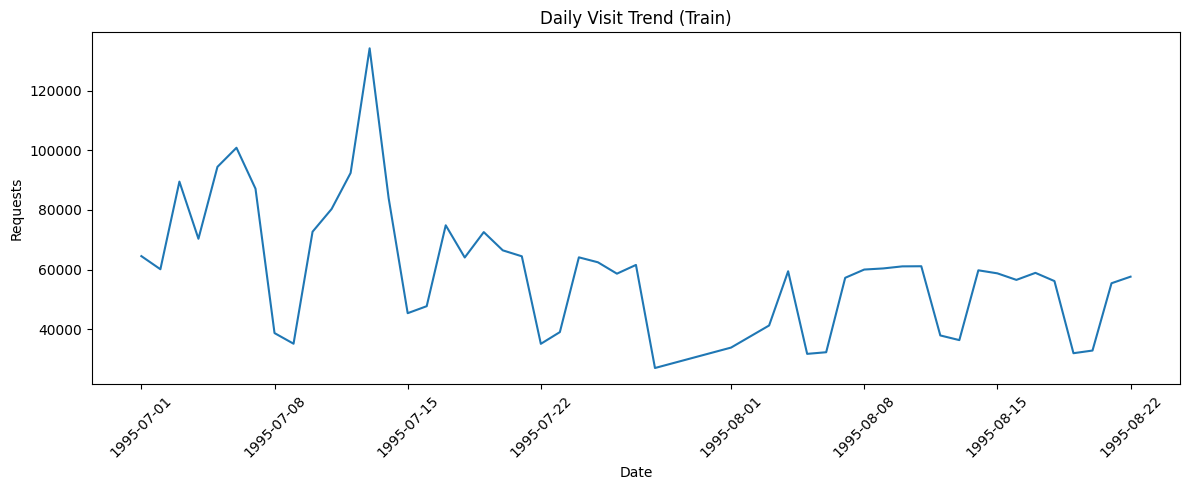

In [87]:
# ensure datetime is datetime type
train["datetime"] = pd.to_datetime(train["datetime"], errors="coerce")

# group by day
train_daily = (
    train.groupby(train["datetime"].dt.date)
         .size()
         .sort_index()
)

plt.figure(figsize=(12,5))
plt.plot(train_daily.index, train_daily.values)
plt.xlabel("Date")
plt.ylabel("Requests")
plt.title("Daily Visit Trend (Train)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

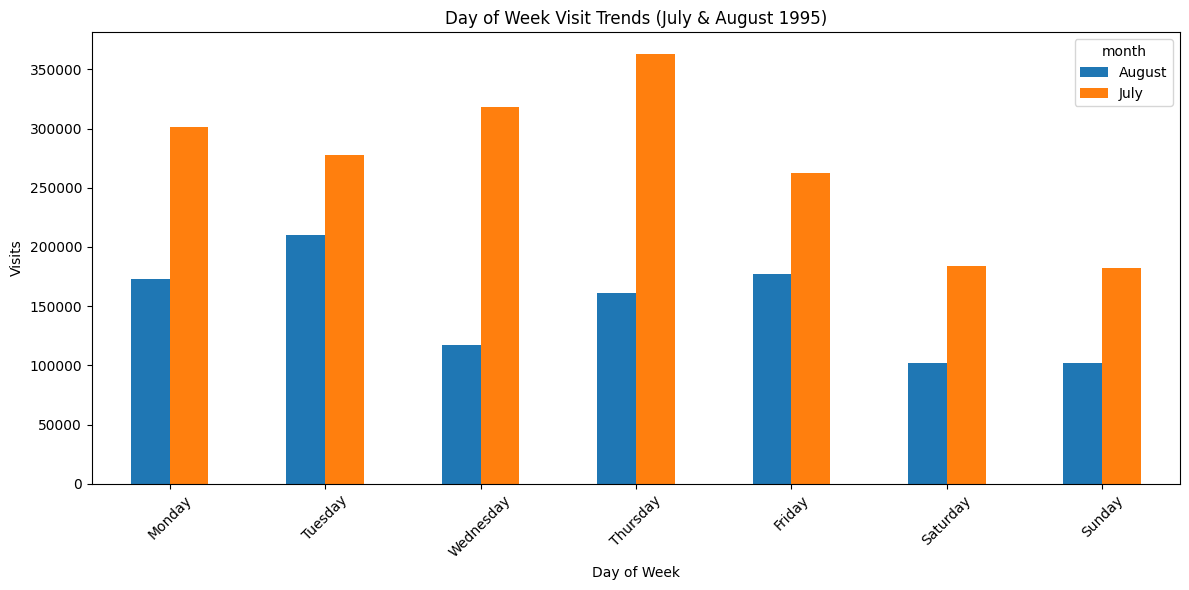

In [89]:

# ensure datetime is parsed
train["datetime"] = pd.to_datetime(train["datetime"], errors="coerce")

# keep only July & August 1995
df = train[
    (train["datetime"].dt.year == 1995) &
    (train["datetime"].dt.month.isin([7, 8]))
].copy()

# add month and weekday name
df["month"] = df["datetime"].dt.month.map({7: "July", 8: "August"})
df["weekday"] = df["datetime"].dt.day_name()

# order weekdays correctly
weekday_order = [
    "Monday", "Tuesday", "Wednesday",
    "Thursday", "Friday", "Saturday", "Sunday"
]

# aggregate visits
weekday_visits = (
    df.groupby(["month", "weekday"])
      .size()
      .unstack("month")
      .reindex(weekday_order)
)

# plot
weekday_visits.plot(kind="bar", figsize=(12, 6))
plt.xlabel("Day of Week")
plt.ylabel("Visits")
plt.title("Day of Week Visit Trends (July & August 1995)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
